#### Library

In [1]:
import pandas as pd
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

#### Data Loading

In [2]:
df = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/merged_df_2024.csv')

#### Data Processing

In [3]:
df.shape

(8787, 67)

In [4]:
df.head()

,datetime_,pool_price,forecast_pool_price,rolling_30day_avg_price,alberta_internal_load,forecast_alberta_internal_load,solar_generation,wind_generation,temp_calgary,temp_edmonton,temp_fortmc,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,week_of_month,month,season,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2024-01-01 00:00:00,23.05,20.57,51.98,9809.0,9779.0,0.0,2905.627906,3.0,-0.5,2.5,8.0,10.0,16.0,0,0,1,1,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 01:00:00,22.67,19.69,51.97,9702.0,9709.0,0.0,2857.032152,3.0,-2.5,2.0,5.0,7.0,16.0,1,0,1,1,winter,23.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 02:00:00,24.07,21.46,51.96,9560.0,9615.0,0.0,2519.803339,3.2,-4.3,0.7,5.0,9.0,16.0,2,0,1,1,winter,22.67,23.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9702.0,9809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 03:00:00,24.33,24.21,51.93,9547.0,9510.0,0.0,2386.924303,2.9,-3.5,-0.5,16.0,12.0,14.0,3,0,1,1,winter,24.07,22.67,23.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9560.0,9702.0,9809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 04:00:00,24.70,24.48,51.93,9511.0,9545.0,0.0,2222.338043,2.4,-4.7,0.1,19.0,5.0,16.0,4,0,1,1,winter,24.33,24.07,22.67,23.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9547.0,9560.0,9702.0,9809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isnull().sum().sort_values(ascending=False)

alberta_internal_load_lag_24      25
pool_price_lag_24                 25
alberta_internal_load_lag_23      24
pool_price_lag_23                 24
alberta_internal_load_lag_22      23
pool_price_lag_22                 23
pool_price_lag_21                 22
alberta_internal_load_lag_21      22
alberta_internal_load_lag_20      21
pool_price_lag_20                 21
alberta_internal_load_lag_19      20
pool_price_lag_19                 20
alberta_internal_load_lag_18      19
pool_price_lag_18                 19
pool_price_lag_17                 18
alberta_internal_load_lag_17      18
pool_price_lag_16                 17
alberta_internal_load_lag_16      17
alberta_internal_load_lag_15      16
pool_price_lag_15                 16
alberta_internal_load_lag_14      15
temp_edmonton                     15
ws_edmonton                       15
pool_price_lag_14                 15
alberta_internal_load_lag_13      14
pool_price_lag_13                 14
alberta_internal_load_lag_12      13
p

In [6]:
# Filter columns that do not start with 'alberta' or 'pool'
filtered_columns = [col for col in df.columns if not col.startswith('alberta') and not col.startswith('pool')]

# Display the sum of null values for the filtered columns
df[filtered_columns].isnull().sum()#.sort_values(ascending=False)

datetime_                          0
forecast_pool_price                1
rolling_30day_avg_price            1
forecast_alberta_internal_load     1
solar_generation                   1
wind_generation                    1
temp_calgary                       9
temp_edmonton                     15
temp_fortmc                        8
ws_calgary                        11
ws_edmonton                       15
ws_fortmc                          8
hour_of_day                        0
day_of_week                        0
week_of_month                      0
month                              0
season                             0
dtype: int64

In [7]:
# impute median for missing values

df['pool_price'].fillna(df.pool_price.median(), inplace=True)
df['alberta_internal_load'].fillna(df.alberta_internal_load.median(), inplace=True)

df['forecast_pool_price'].fillna(df.forecast_pool_price.median(), inplace=True)
df['rolling_30day_avg_price'].fillna(df.rolling_30day_avg_price.median(), inplace=True)
df['forecast_alberta_internal_load'].fillna(df.forecast_alberta_internal_load.median(), inplace=True)

df['solar_generation'].fillna(df.solar_generation.median(), inplace=True)
df['wind_generation'].fillna(df.wind_generation.median(), inplace=True)

df['temp_calgary'].fillna(df.temp_calgary.median(), inplace=True)
df['temp_edmonton'].fillna(df.temp_edmonton.median(), inplace=True)
df['temp_fortmc'].fillna(df.temp_fortmc.median(), inplace=True)

df['ws_calgary'].fillna(df.ws_calgary.median(), inplace=True)
df['ws_edmonton'].fillna(df.ws_edmonton.median(), inplace=True)
df['ws_fortmc'].fillna(df.ws_fortmc.median(), inplace=True)

/tmp/ipykernel_11367/4150987496.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pool_price'].fillna(df.pool_price.median(), inplace=True)
/tmp/ipykernel_11367/4150987496.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [8]:
df.isnull().sum()

datetime_                          0
pool_price                         0
forecast_pool_price                0
rolling_30day_avg_price            0
alberta_internal_load              0
forecast_alberta_internal_load     0
solar_generation                   0
wind_generation                    0
temp_calgary                       0
temp_edmonton                      0
temp_fortmc                        0
ws_calgary                         0
ws_edmonton                        0
ws_fortmc                          0
hour_of_day                        0
day_of_week                        0
week_of_month                      0
month                              0
season                             0
pool_price_lag_1                   2
pool_price_lag_2                   3
pool_price_lag_3                   4
pool_price_lag_4                   5
pool_price_lag_5                   6
pool_price_lag_6                   7
pool_price_lag_7                   8
pool_price_lag_8                   9
p

In [9]:
# fill NAN with bfill method
lagged_columns = [f'pool_price_lag_{i}' for i in range(1, 25)] + [f'alberta_internal_load_lag_{i}' for i in range(1, 25)]

df[lagged_columns] = df[lagged_columns].fillna(method='bfill')
# Verify if NaN values are filled
print(df[lagged_columns].isnull().sum().sort_values(ascending=False))

pool_price_lag_1                0
pool_price_lag_2                0
alberta_internal_load_lag_3     0
alberta_internal_load_lag_4     0
alberta_internal_load_lag_5     0
alberta_internal_load_lag_6     0
alberta_internal_load_lag_7     0
alberta_internal_load_lag_8     0
alberta_internal_load_lag_9     0
alberta_internal_load_lag_10    0
alberta_internal_load_lag_11    0
alberta_internal_load_lag_12    0
alberta_internal_load_lag_13    0
alberta_internal_load_lag_14    0
alberta_internal_load_lag_15    0
alberta_internal_load_lag_16    0
alberta_internal_load_lag_17    0
alberta_internal_load_lag_18    0
alberta_internal_load_lag_19    0
alberta_internal_load_lag_20    0
alberta_internal_load_lag_21    0
alberta_internal_load_lag_22    0
alberta_internal_load_lag_23    0
alberta_internal_load_lag_2     0
alberta_internal_load_lag_1     0
pool_price_lag_24               0
pool_price_lag_12               0
pool_price_lag_3                0
pool_price_lag_4                0
pool_price_lag

/tmp/ipykernel_11367/1257025338.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[lagged_columns] = df[lagged_columns].fillna(method='bfill')


In [10]:
# we have 12 months of data

# use 11 months of data to train ML model
    # independent variable: solar_generation, wind_generation, temp_calgary, temp_edmonton, temp_fortmc
    # target variable: pool_price

# use 1 month of data to test ML model

In [11]:
df.head()

,datetime_,pool_price,forecast_pool_price,rolling_30day_avg_price,alberta_internal_load,forecast_alberta_internal_load,solar_generation,wind_generation,temp_calgary,temp_edmonton,temp_fortmc,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,week_of_month,month,season,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2024-01-01 00:00:00,23.05,20.57,51.98,9809.0,9779.0,0.0,2905.627906,3.0,-0.5,2.5,8.0,10.0,16.0,0,0,1,1,winter,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0
1,2024-01-01 01:00:00,22.67,19.69,51.97,9702.0,9709.0,0.0,2857.032152,3.0,-2.5,2.0,5.0,7.0,16.0,1,0,1,1,winter,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0
2,2024-01-01 02:00:00,24.07,21.46,51.96,9560.0,9615.0,0.0,2519.803339,3.2,-4.3,0.7,5.0,9.0,16.0,2,0,1,1,winter,22.67,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,9702.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0
3,2024-01-01 03:00:00,24.33,24.21,51.93,9547.0,9510.0,0.0,2386.924303,2.9,-3.5,-0.5,16.0,12.0,14.0,3,0,1,1,winter,24.07,22.67,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,9560.0,9702.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0
4,2024-01-01 04:00:00,24.70,24.48,51.93,9511.0,9545.0,0.0,2222.338043,2.4,-4.7,0.1,19.0,5.0,16.0,4,0,1,1,winter,24.33,24.07,22.67,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,23.05,9547.0,9560.0,9702.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0,9809.0


In [12]:
df.shape

(8787, 67)

In [13]:
df.isnull().sum().sort_values(ascending=False)

datetime_                         0
alberta_internal_load_lag_8       0
pool_price_lag_18                 0
pool_price_lag_19                 0
pool_price_lag_20                 0
pool_price_lag_21                 0
pool_price_lag_22                 0
pool_price_lag_23                 0
pool_price_lag_24                 0
alberta_internal_load_lag_1       0
alberta_internal_load_lag_2       0
alberta_internal_load_lag_3       0
alberta_internal_load_lag_4       0
alberta_internal_load_lag_5       0
alberta_internal_load_lag_6       0
alberta_internal_load_lag_7       0
alberta_internal_load_lag_9       0
pool_price_lag_16                 0
alberta_internal_load_lag_10      0
alberta_internal_load_lag_11      0
alberta_internal_load_lag_12      0
alberta_internal_load_lag_13      0
alberta_internal_load_lag_14      0
alberta_internal_load_lag_15      0
alberta_internal_load_lag_16      0
alberta_internal_load_lag_17      0
alberta_internal_load_lag_18      0
alberta_internal_load_lag_19

#### Train-Test split

In [15]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-12-01']
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
# X_train = train_data[['solar_generation', 'wind_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc']]
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']

# Display the shapes of the training data
print(X_train.shape, y_train.shape)


# Filter data for the first 6 months
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']

# Display the shapes of the training data
print(X_test.shape, y_test.shape)

(8043, 65) (8043,)
(744, 65) (744,)


#### Model Training

In [17]:
# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')

# Specify the categorical features
categorical_features = ['season'] 

# Train the model
catboost_regressor.fit(X_train, y_train, cat_features=categorical_features, verbose=100)

# Display the model
print(catboost_regressor)

0:	learn: 119.4112984	total: 102ms	remaining: 1m 41s
100:	learn: 32.4789371	total: 1.51s	remaining: 13.5s
200:	learn: 25.5274800	total: 3.07s	remaining: 12.2s
300:	learn: 20.9713971	total: 4.97s	remaining: 11.5s
400:	learn: 17.7557747	total: 6.28s	remaining: 9.38s
500:	learn: 15.2251081	total: 7.58s	remaining: 7.55s
600:	learn: 13.3177761	total: 8.83s	remaining: 5.86s
700:	learn: 11.7755819	total: 10.3s	remaining: 4.41s
800:	learn: 10.4989103	total: 11.5s	remaining: 2.85s
900:	learn: 9.4245623	total: 12.6s	remaining: 1.39s
999:	learn: 8.5392703	total: 13.8s	remaining: 0us


#### Train Inference

In [18]:
# Make predictions on the training data
y_train_pred = catboost_regressor.predict(X_train)

# Display the predictions
print(y_train_pred)
# Calculate mean squared error for training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {train_mse}")

# Calculate R^2 score for training data
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train R^2 Score: {train_r2}")

[22.04023465 21.30839827 22.35470326 ... 41.44580709 36.99194817
 28.04872939]
Train Mean Squared Error: 72.91913904486404
Train R^2 Score: 0.9956236617050939


#### Test Inference

In [19]:
# Make predictions on the test data
y_pred = catboost_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error: 425.5425810894825
R^2 Score: 0.18935391816155667


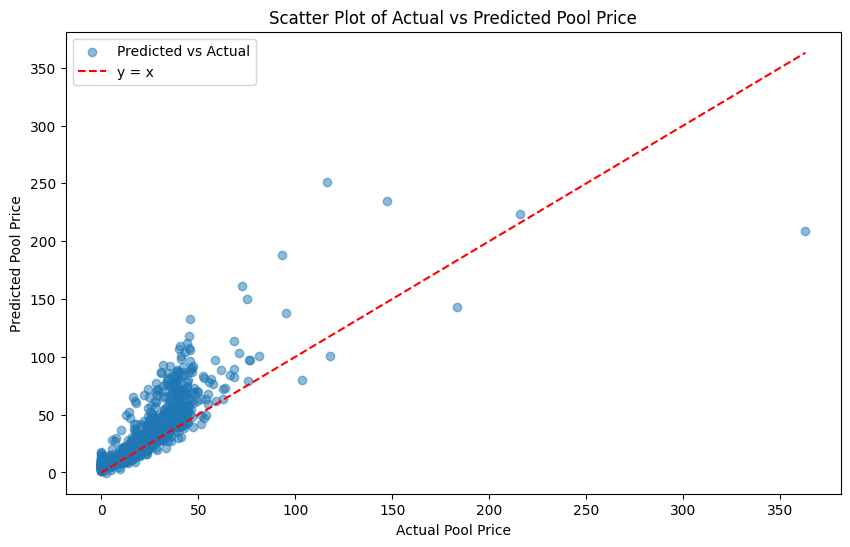

In [20]:
# Assuming y_test and y_pred are already defined
# Generate values for the y = x line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line_values = np.linspace(min_val, max_val, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot the y = x line
plt.plot(line_values, line_values, color='red', linestyle='--', label='y = x')

# Add labels and title
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Scatter Plot of Actual vs Predicted Pool Price')

# Add a legend
plt.legend()

# Show the plot
plt.show()